In [13]:
from scipy import io
import os
import numpy as np
from scipy.sparse.linalg import eigsh
import matplotlib.pyplot as plt
%matplotlib inline
import utils_cvPCA

os.chdir('e:\\Python\\molanalysis\\cvPCA')
# dat = io.loadmat('/media/carsen/DATA2/grive/10krecordings/imgResp/natimg2800_M170714_MP032_2017-09-14.mat')
dat = io.loadmat('natimg2800_M170714_MP032_2017-09-14.mat')
# dat = io.loadmat('/cvPCA/natimg2800_M170714_MP032_2017-09-14.mat')

resp = dat['stim'][0]['resp'][0] # stim x neurons
spont = dat['stim'][0]['spont'][0] # timepts x neurons
istim = (dat['stim'][0]['istim'][0]).astype(np.int32) # stim ids 
istim -= 1 # get out of MATLAB convention
istim = istim[:,0]
nimg = istim.max() # these are blank stims (exclude them)
resp = resp[istim<nimg, :]
istim = istim[istim<nimg]

# subtract spont (32D)
mu = spont.mean(axis=0)
sd = spont.std(axis=0) + 1e-6
resp = (resp - mu) / sd
spont = (spont - mu) / sd
sv,u = eigsh(spont.T @ spont, k=32)
resp = resp - (resp @ u) @ u.T

# mean center each neuron
resp -= resp.mean(axis=0)

KeyboardInterrupt: 

In [2]:
from scipy import io
import os
import numpy as np
from scipy.sparse.linalg import eigsh
import matplotlib.pyplot as plt
%matplotlib inline
import utils_cvPCA

import pandas as pd
import scipy.stats as st
os.chdir('e:\\Python\\molanalysis\\')
from loaddata.session_info import filter_sessions,load_sessions

from utils.plot_lib import * #get all the fixed color schemes
from utils.imagelib import load_natural_images #
from utils.corr_lib import mean_resp_image

#################################################
# session_list        = np.array([['LPE09665','2023_03_15']])
session_list        = np.array([['LPE11086_2023_12_16']])

#%% Load sessions lazy: 
sessions,nSessions  = filter_sessions(protocols = 'IM',only_session_id=session_list)

#%%   Load proper data and compute average trial responses:                      
for ises in range(nSessions):    # iterate over sessions
    # sessions[ises].load_respmat(load_behaviordata=True, load_calciumdata=True,load_videodata=True,calciumversion='deconv')
    sessions[ises].load_respmat(calciumversion='deconv',keepraw=True)

In [3]:
resp = sessions[0].respmat.T
np.shape(resp)
istim = np.array(sessions[0].trialdata['ImageNumber'])
istim
nimg = istim.max() + 1 # these are blank stims (exclude them)
nimg

# mean center each neuron
resp -= resp.mean(axis=0)
resp = resp / (resp.std(axis=0) + 1e-6)


In [4]:
### sanity check - decent signal variance ?
# split stimuli into two repeats
NN = resp.shape[1]
sresp = np.zeros((2, nimg, NN), np.float64)
inan = np.zeros((nimg,)).astype(bool)
for n in range(nimg):
    ist = (istim==n).nonzero()[0]
    i1 = ist[:int(ist.size/2)]
    i2 = ist[int(ist.size/2):]
    # check if two repeats of stim
    if np.logical_or(i2.size < 1, i1.size < 1):
        inan[n] = 1
    else:
        sresp[0, n, :] = resp[i1, :].mean(axis=0)
        sresp[1, n, :] = resp[i2, :].mean(axis=0)
        
# remove image responses without two repeats
sresp = sresp[:,~inan,:]

# normalize the responses across images
# Subtract that mean, and divide by std — this makes the response of each neuron
# for each repeat zero-mean and unit-variance across stimuli.
# So now, for each neuron, the normalized responses to different stimuli 
# are on the same scale in both repeats.
snorm = sresp - sresp.mean(axis=1)[:,np.newaxis,:]
snorm = snorm / (snorm.std(axis=1)[:,np.newaxis,:] + 1e-6)

#Get the correlation of each neuron's response across repeats
cc = (snorm[0].T @ snorm[1]) / sresp.shape[1]
#print the mean correlation coeff:
print('fraction of signal variance: %2.3f'%np.diag(cc).mean())

fraction of signal variance: 0.201


(array([ 4.,  3., 10., 16., 26., 32., 35., 39., 40., 56., 51., 68., 46.,
        43., 49., 51., 45., 39., 52., 35., 57., 43., 54., 35., 39., 56.,
        36., 48., 29., 32., 47., 47., 35., 47., 48., 36., 48., 40., 36.,
        49., 34., 40., 49., 35., 40., 41., 34., 45., 35., 25., 36., 24.,
        34., 35., 30., 30., 31., 21., 21., 31., 31., 29., 23., 26., 20.,
        16., 14.,  7., 16., 10., 12., 10.,  6., 13., 13., 11.,  4.,  4.,
         5.,  6.,  5.,  1.,  2.,  4.,  1.,  1.,  5.,  4.,  1.,  0.,  2.,
         5.,  3.,  1.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-0.03318817, -0.02639712, -0.01960606, -0.01281501, -0.00602395,
         0.0007671 ,  0.00755816,  0.01434921,  0.02114027,  0.02793132,
         0.03472238,  0.04151343,  0.04830449,  0.05509554,  0.06188659,
         0.06867765,  0.0754687 ,  0.08225976,  0.08905081,  0.09584187,
         0.10263292,  0.10942398,  0.11621503,  0.12300609,  0.12979714,
         0.1365882 ,  0.14337925,  0.15017031,  0.15696136,  0.163752

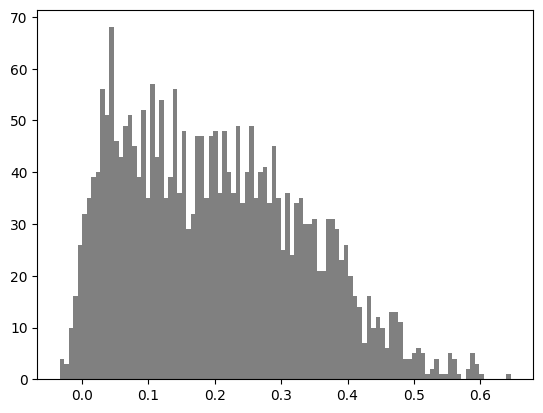

In [ ]:
# make a histogram of the corr coefs for all neurons:
plt.hist(np.diag(cc),bins=100,color='grey')

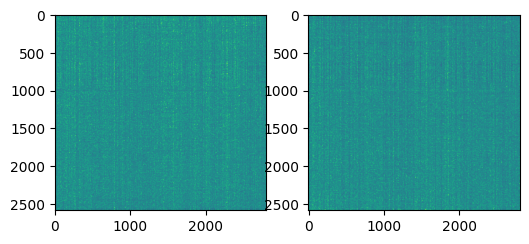

In [18]:
fig,axes = plt.subplots(1,2,figsize=(6,8))
ax = axes[0]
ax.imshow(sresp[0].T,vmin=-1,vmax=1)
ax = axes[1]
ax.imshow(sresp[1].T,vmin=-1,vmax=1)

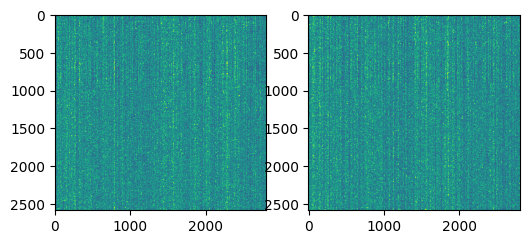

In [19]:
fig,axes = plt.subplots(1,2,figsize=(6,8))
ax = axes[0]
ax.imshow(snorm[0].T,vmin=-0.5,vmax=0.5)
ax = axes[1]
ax.imshow(snorm[1].T,vmin=-0.5,vmax=0.5)

In [ ]:
sresp.shape
cc = sresp[0] @ sresp[1].T
np.shape(cc)

(2800, 2800)

In [5]:
### sanity check - decent decoding ?
# 1 nearest neighbor decoder    
# (mean already subtracted)
# sresp = snorm
cc = sresp[0] @ sresp[1].T
cc /= (sresp[0]**2).sum()
cc /= (sresp[1]**2).sum()
nstims = sresp.shape[1]
print('decoding accuracy: %2.3f'%(cc.argmax(axis=1)==np.arange(0,nstims,1,int)).mean())

decoding accuracy: 0.344


powerlaw, alpha=0.894


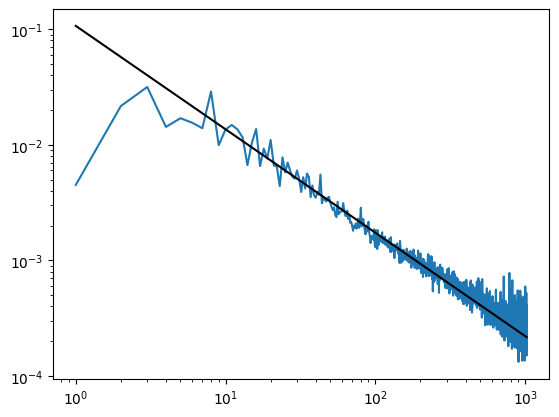

In [25]:
### sanity check - is the powerlaw close to 1 ?
# powerlaw

# compute cvPCA
# ss = utils_cvPCA.shuff_cvPCA(sresp)
# ss = ss.mean(axis=0)

ss = utils_cvPCA.cvPCA(sresp)

# compute powerlaw of averaged shuffles
alpha,ypred = utils_cvPCA.get_powerlaw(ss/ss.sum(), np.arange(11,5e2).astype(int))  
print('powerlaw, alpha=%2.3f'%alpha)

plt.loglog(np.arange(0,ss.size)+1, ss/ss.sum())
plt.loglog(np.arange(0,ss.size)+1, ypred, c='k')
plt.show()


In [ ]:
from sklearn.decomposition import PCA

idx_V1 = sessions[0].celldata['roi_name']=='V1'
idx_PM = sessions[0].celldata['roi_name']=='PM'

minNneurons = np.min([X.shape[2], Y.shape[2]])


X = np.ascontiguousarray(sresp[:,:,idx_V1])
Y = np.ascontiguousarray(sresp[:,:,idx_PM])

X = np.ascontiguousarray(X[:, :, :minNneurons])
Y = np.ascontiguousarray(Y[:, :, :minNneurons])

In [46]:
print(np.shape(X))
print(np.shape(Y))


(2, 2800, 903)
(2, 2800, 903)


In [47]:
def cvPCA(X):
    ''' X is 2 x stimuli x neurons '''
    # do PCA on data
    # pca = PCA(n_components=min(1024, X.shape[1])).fit(X[0].T)
    pca = PCA(n_components=min(512, X.shape[2])).fit(X[0].T)
    # get the components
    u = pca.components_.T
    # get the singular values
    sv = pca.singular_values_
    
    # project train data onto components
    xproj = X[0].T @ (u / sv)
    # project train data onto components
    cproj0 = X[0] @ xproj
    # project test data onto components
    cproj1 = X[1] @ xproj
    
    # compute the correlation between the two sets of components
    ss = (cproj0 * cproj1).sum(axis=0)
    return ss

powerlaw, alpha=0.957


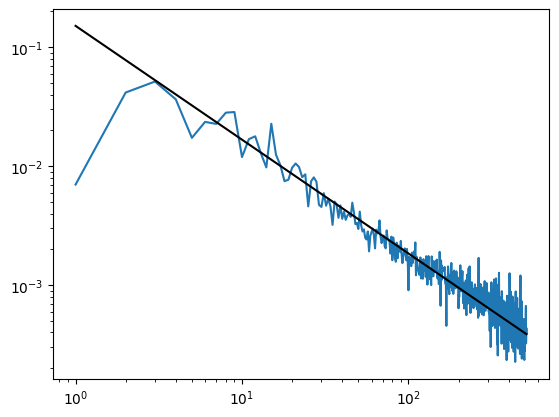

In [49]:
ss = cvPCA(Y)

# compute powerlaw of averaged shuffles
alpha,ypred = utils_cvPCA.get_powerlaw(ss/ss.sum(), np.arange(11,5e2).astype(int))  
print('powerlaw, alpha=%2.3f'%alpha)

plt.loglog(np.arange(0,ss.size)+1, ss/ss.sum())
plt.loglog(np.arange(0,ss.size)+1, ypred, c='k')
plt.show()

In [23]:

''' X is 2 x stimuli x neurons '''
# do PCA on data
pca = PCA(n_components=min(1024, X.shape[1])).fit(X[0].T)
# get the components
u = pca.components_.T
# get the singular values
sv = pca.singular_values_


In [24]:
# project train data onto components
xproj = X[0].T @ (u / sv)
# project train data onto components
cproj0 = X[0] @ xproj
# project test data onto components
cproj1 = X[1] @ xproj

# compute the correlation between the two sets of components
ss = (cproj0 * cproj1).sum(axis=0)

KeyboardInterrupt: 

In [36]:
import numpy as np
from scipy.sparse.linalg import eigsh
from sklearn.decomposition import PCA

# do PCA on data
pca = PCA(n_components=min(1024, X.shape[1])).fit(X[0].T)
# get the components
u = pca.components_.T
# get the singular values
sv = pca.singular_values_


In [41]:
print(np.shape(u))
print(np.shape(sv))

(2800, 1024)
(1024,)


In [66]:
# do PLS on X and Y, get the components of PLS for each of the areas, as well as the singular values
from sklearn.cross_decomposition import PLSCanonical

n_components = np.min([1024, X.shape[2], Y.shape[2]])
n_components = 256
pls = PLSCanonical(n_components=n_components,max_iter=50,algorithm='nipals').fit(X[0].T, Y[0].T)
# get the components
u_x = pls.x_weights_
u_y = pls.y_weights_

# print(pls.x_scores_)
X_c, Y_c = pls.transform(X[0].T, Y[0].T)

# Get the singular values of the different components
sv_x = np.sqrt(np.sum(X_c ** 2, axis=0))
sv_y = np.sqrt(np.sum(Y_c** 2, axis=0))

c:\Users\Matthijs\Anaconda\envs\molanalysis\lib\site-packages\sklearn\cross_decomposition\_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


In [67]:
print(np.shape(u_x))
print(np.shape(sv_x))

(2800, 256)
(256,)


In [68]:
# project train data onto components
xproj = X[0].T @ (u_x / sv_x)
# # project train data onto components
cproj0 = X[0] @ xproj
# # project test data onto components
cproj1 = X[1] @ xproj

# # compute the correlation between the two sets of components
ss_x = (cproj0 * cproj1).sum(axis=0)

# project train data onto components
yproj = Y[0].T @ (u_y / sv_y)
# project train data onto components
cproj0 = Y[0] @ yproj
# project test data onto components
cproj1 = Y[1] @ yproj

# compute the correlation between the two sets of components
ss_y = (cproj0 * cproj1).sum(axis=0)

In [26]:
# project train data onto components
xproj = X[0].T @ (u / sv)
# project train data onto components
cproj0 = X[0] @ xproj
# project test data onto components
cproj1 = X[1] @ xproj

# compute the correlation between the two sets of components
ss = (cproj0 * cproj1).sum(axis=0)


NameError: name 'sv' is not defined

In [49]:
np.shape(pca.transform(X[0].T))

(9476, 1024)

powerlaw, alpha=0.776
powerlaw, alpha=0.579


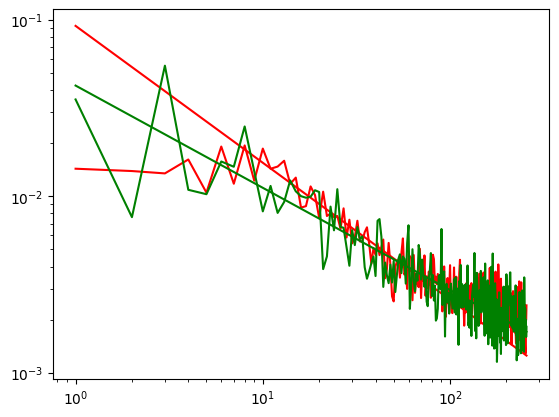

In [70]:
# compute powerlaw of averaged shuffles
alpha_x,ypred_x = utils_cvPCA.get_powerlaw(ss_x/ss_x.sum(), np.arange(11,1e2).astype(int))  
print('powerlaw, alpha=%2.3f'%alpha_x)

plt.loglog(np.arange(0,ss_x.size)+1, ss_x/ss_x.sum(), c='r')
plt.loglog(np.arange(0,ss_x.size)+1, ypred_x, c='r')

# alpha,ypred = utils_cvPCA.get_powerlaw(ss_x/ss_x.sum(), np.arange(11,5e2).astype(int))  
alpha_y,ypred_y = utils_cvPCA.get_powerlaw(ss_y/ss_y.sum(), np.arange(11,n_components).astype(int))  
print('powerlaw, alpha=%2.3f'%alpha_y)

plt.loglog(np.arange(0,ss_y.size)+1, ss_y/ss_y.sum(), c='g')
plt.loglog(np.arange(0,ss_y.size)+1, ypred_y, c='g')
plt.show()

powerlaw, alpha=0.957


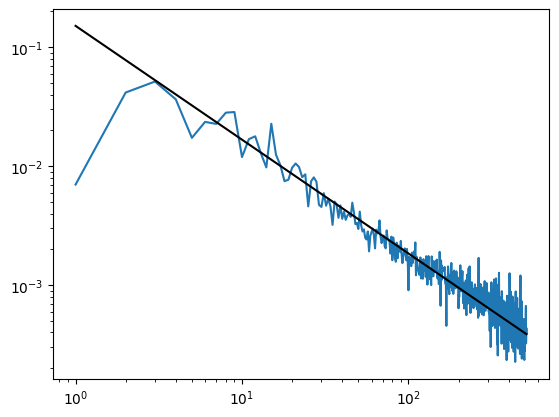

In [60]:
# compute powerlaw of averaged shuffles
alpha,ypred = utils_cvPCA.get_powerlaw(ss/ss.sum(), np.arange(11,5e2).astype(int))  
print('powerlaw, alpha=%2.3f'%alpha)

plt.loglog(np.arange(0,ss.size)+1, ss/ss.sum())
plt.loglog(np.arange(0,ss.size)+1, ypred, c='k')
plt.show()